#### 自作モジュールの参照先を上書き

In [1]:
import sys

parent_dir = 'Predict-Future-Sales'
p_sub = sys.path[0]

ride = ''
for path in p_sub.split('/'):
    if path != parent_dir:
        ride = ride + path + '/'
    else:
        ride = ride + path + '/'
        break
sys.path[0] = ride

In [2]:
import time
import pickle

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt

from module.lino_module.preprocess import select_device, time_series_dataset
from module.lino_module.model import TransformerModel

/Users/lino/opt/anaconda3/envs/for_pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## データセットの準備

In [3]:
data = pd.read_csv('../data/sales_train.csv')
seq = 7
d_model = 64
dilation = 1
train, test = time_series_dataset(data, seq=seq, d_model=d_model, dilation=dilation)

## 訓練用モデルの準備

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
nhead=8
transformer = TransformerModel(d_model, nhead).to(device)
criterion = nn.MSELoss()

step_num = 1
warmup_steps = 5000
lr = d_model**0.5 * min(step_num**0.5, step_num * warmup_steps**(-1.5))
optimizer = Adam(transformer.parameters(), lr=1e-5, betas=(0.95, 0.98), eps=10e-9)

## モデル訓練

In [5]:
epochs = 100
train_loss = []
test_loss = []

verbose = 10
center = 80

print(' start '.center(center, '-'))
start_point = time.time()
for epoch in range(epochs):
    epoch_point = time.time()
    train_epoch_loss = []
    test_epoch_loss = []

    for i, pack in enumerate(train):
        src, tgt, y = [content.to(device) for content in pack]
        # モデル訓練
        if i == 0:
            pass
        else:
            # キャッシュから１バッチ前のデータで訓練
            cached_src, cached_tgt, cached_y = cach
            transformer.train()
            optimizer.zero_grad()
            output = transformer(cached_src, cached_tgt)
            loss = criterion(output[:, 1, :], cached_y)
            train_epoch_loss.append(loss.item())
            # 勾配計算
            loss.backward()
            optimizer.step()

        # モデル評価
        transformer.eval()
        output = transformer(src, tgt)
        loss = criterion(output[:, 1, :], y)
        test_epoch_loss.append(loss.item())
        # データをキャッシュに保存して次回の訓練データにする
        cach = (src, tgt, y)

    test_loss_mean = torch.mean(torch.tensor(test_epoch_loss))
    test_loss.append(test_loss_mean)
    try:
        train_loss_mean = torch.mean(torch.tensor(train_epoch_loss))
        train_loss.append(train_loss_mean)
    except:  # 1バッチ目の訓練は存在しないたエラーをパス
        pass
    
    if epoch % verbose == 0:
        print(f' epoch_{epoch} '.center(center))
        print('train_loss: ', train_loss_mean,
            '| test_loss: ', test_loss_mean,
            '| time: ', round(time.time() - epoch_point, 3))

print(' complete!! '.center(center, '-'))
print(f'Execution_time: {round(time.time() - start_point, 3)}')

------------------------------------ start -------------------------------------
                                    epoch_0                                     
train_loss:  tensor(1.5240) | test_loss:  tensor(1.5451) | time:  2.014
                                    epoch_10                                    
train_loss:  tensor(0.6282) | test_loss:  tensor(0.5325) | time:  1.788
                                    epoch_20                                    
train_loss:  tensor(0.4991) | test_loss:  tensor(0.3943) | time:  1.836
                                    epoch_30                                    
train_loss:  tensor(0.4076) | test_loss:  tensor(0.3218) | time:  1.824
                                    epoch_40                                    
train_loss:  tensor(0.3468) | test_loss:  tensor(0.2725) | time:  1.843
                                    epoch_50                                    
train_loss:  tensor(0.3277) | test_loss:  tensor(0.2358) | time:  2.374
 

train_loss:  tensor(0.2949) | test_loss:  tensor(0.2148) | time:  1.411

### 訓練データ損失と検証データ損失

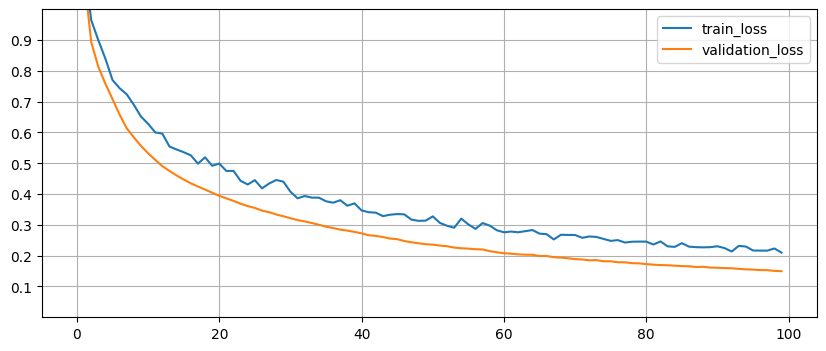

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label=('train_loss'))
plt.plot(test_loss, label='validation_loss')
plt.legend()
plt.yticks([round(i*1e-1, 1) for i in range(1, 10)])
plt.grid(axis='x')
plt.grid(axis='y')
plt.ylim(0, 1)
img_path = '../osada_notebook/img/'
plt.savefig(img_path + f'Loss(epoch{epochs}_dmodel{d_model}_dilation{dilation}).png')
plt.show()

### 訓練データとテストデータで予測

In [7]:
transformer.eval()
train_preds = []
for src, tgt, _ in train:
    train_pred = transformer(src, tgt)
    train_preds.append(train_pred[:, -1])

test_preds = []
for src, tgt, _ in test:
    test_pred = transformer(src, tgt)
    test_preds.append(test_pred[:, -1])

In [8]:
import datetime
from module.lino_module.preprocess import _mode_of_freq

# 比較用に訓練に使用した時系列データを用意
original = _mode_of_freq(data).item_cnt_day
# 訓練データ, テストデータとのラグを計算
lag = d_model * dilation + seq

fit_target = original.values.reshape(-1,1)
src = StandardScaler().fit(fit_target)

# 予測データを ndarray に変換してプロットできるようにする
train_pred = torch.concat(train_preds).reshape(-1).detach().numpy()
test_pred = torch.concat(test_preds).reshape(-1).detach().numpy()

# 予測データの標準化を解除
train_pred = src.inverse_transform(train_pred.reshape(-1, 1)).reshape(-1)
test_pred = src.inverse_transform(test_pred.reshape(-1, 1)).reshape(-1)

In [9]:
# 訓練データラベルのラグを修正
tr_start = original.index[0] + datetime.timedelta(lag)
tr_end = tr_start + datetime.timedelta(len(train_pred) - 1)
tr_idx = pd.date_range(tr_start, tr_end)
# ラグを修正したインデックスでプロット用の訓練予測データを作成
train_time_series = pd.Series(train_pred, index=tr_idx)

# テストデータのラグを修正
te_start = tr_end + datetime.timedelta(1)
te_end = te_start + datetime.timedelta(len(test_pred) - 1)
te_idx = pd.date_range(te_start, te_end)
# ラグを修正したインデックスでプロロット用のテスト予測データを作成
test_time_series = pd.Series(test_pred, index=te_idx)

### 予測データのプロット

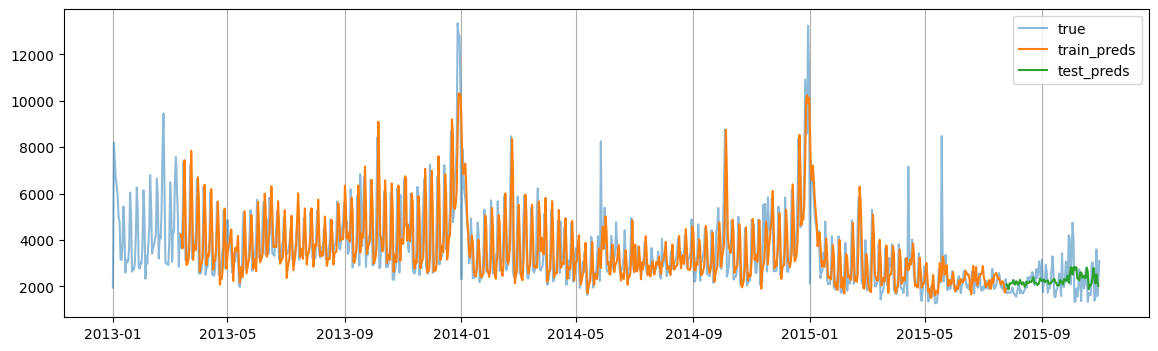

In [10]:
plt.figure(figsize=(14, 4))
plt.plot(original, alpha=0.5, label='true')
plt.plot(train_time_series, label='train_preds')
plt.plot(test_time_series, label='test_preds')
plt.grid(axis='x')
plt.legend()

plt.savefig(img_path + f'Predict(epoch{epochs}_d_model{d_model}_dilation{dilation}).png')
plt.show()